In [1]:
# General Exploratory Data Analysis

In [1]:
import os
import sys
from pathlib import Path

# Get the notebook's directory
notebook_dir = os.getcwd()

# Add the notebook directory and its parent to Python path
sys.path.append(notebook_dir)
sys.path.append(str(Path(notebook_dir).parent))

# Function to add all subdirectories to Python path
def add_subdirs_to_path():
    for root, dirs, files in os.walk(notebook_dir):
        for dir_name in dirs:
            full_path = os.path.join(root, dir_name)
            if full_path not in sys.path:
                sys.path.append(full_path)

# Add all subdirectories
add_subdirs_to_path()

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from feature_engineering import engineer_features
from utils.load_data import load_data
from data_cleaning.data_cleaning import clean_data

In [3]:
train_df = load_data("../data/train.csv")
train_df = engineer_features(train_df)
train_df = clean_data(train_df)

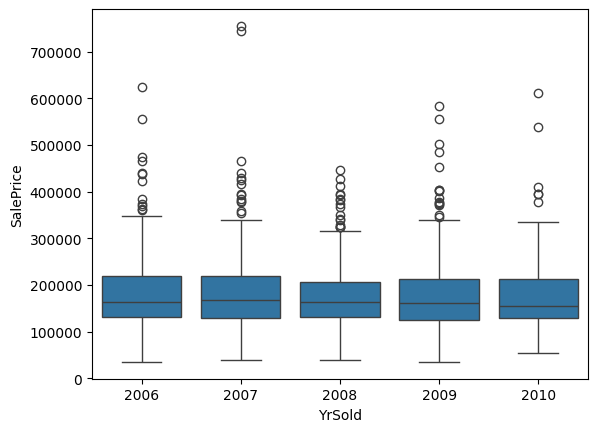

In [4]:
sns.boxplot(data = train_df, x = "YrSold", y = "SalePrice")
plt.show()

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

In [6]:
from utils.prepare_data import prepare_data

Optimal alpha: 0.005245
Number of features selected: 105

Top 20 most important features:
              feature     coef
            GrLivArea 0.130222
     RoofMatl_ClyTile 0.059426
          TotalBsmtSF 0.039436
    grouped_qual_High 0.039315
     MSZoning_C (all) 0.029127
            YearBuilt 0.028957
         YearRemodAdd 0.025886
           GarageCars 0.024950
      Condition2_PosN 0.023357
     grouped_qual_Low 0.023324
           BsmtFinSF1 0.022790
 Neighborhood_Crawfor 0.019981
           GarageArea 0.019952
          MSZoning_RM 0.019150
     grouped_cond_Low 0.016250
SaleCondition_Abnorml 0.015114
        OverallQual_7 0.014767
        MSSubClass_30 0.013477
       Functional_Typ 0.013021
        OverallCond_3 0.013015

R2 score: 0.9298


<module 'matplotlib.pyplot' from 'c:\\Users\\Kyryl\\Projects\\ds\\Kaggle\\house_prices\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

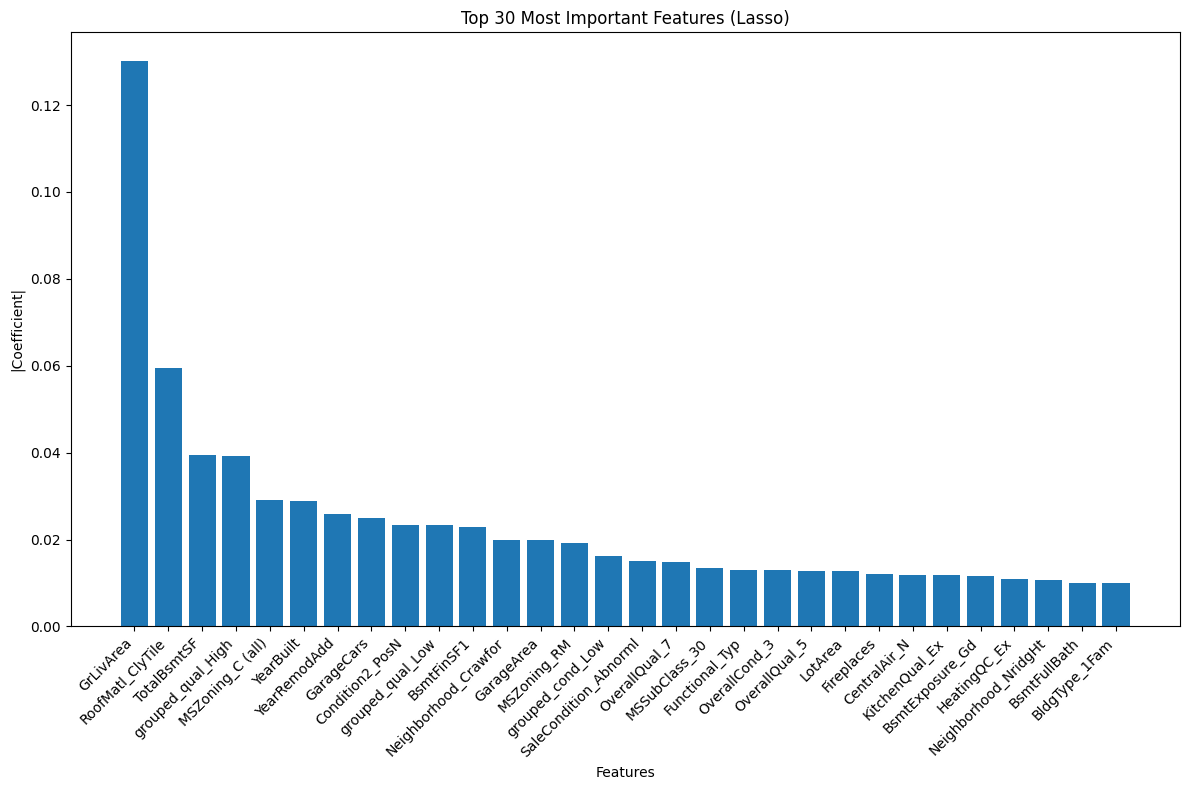

In [8]:
# Fit LassoCV and analyze features
def analyze_lasso_features(X, y):
    """
    Fit LassoCV and return feature importances
    """
    # Setup cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Fit LassoCV
    lasso = LassoCV(cv=cv, random_state=42, max_iter=2000)
    lasso.fit(X, y)
    
    # Get feature importance
    importance = pd.DataFrame({
        'feature': X.columns,
        'coef': np.abs(lasso.coef_)
    })
    importance = importance.sort_values('coef', ascending=False)
    
    print(f"Optimal alpha: {lasso.alpha_:.6f}")
    print(f"Number of features selected: {np.sum(lasso.coef_ != 0)}")
    
    return importance, lasso

# Plot feature importance
def plot_importance(importance, top_n=30):
    """
    Plot top N most important features
    """
    plt.figure(figsize=(12, 8))
    plt.bar(range(top_n), importance['coef'][:top_n])
    plt.xticks(range(top_n), importance['feature'][:top_n], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('|Coefficient|')
    plt.title(f'Top {top_n} Most Important Features (Lasso)')
    plt.tight_layout()
    return plt

# Main analysis
def main():
    # Read data
    
    # Prepare data
    X, y, scaler = prepare_data(train_df)
    
    # Analyze features
    importance, model = analyze_lasso_features(X, y)
    
    # Print top features
    print("\nTop 20 most important features:")
    print(importance.head(20).to_string(index=False))
    
    # Print R2 score
    print(f"\nR2 score: {model.score(X, y):.4f}")
    
    # Return for further analysis if needed
    return importance, model, X, y

importance, model, X, y = main()
plot_importance(importance)

Optimal alpha: 628.029144

Top 20 most important features:
             feature     coef
           GrLivArea 0.032849
    RoofMatl_ClyTile 0.032555
            1stFlrSF 0.026842
    MSZoning_C (all) 0.022130
         TotalBsmtSF 0.020333
        TotRmsAbvGrd 0.019926
            FullBath 0.018473
          GarageCars 0.018010
          GarageArea 0.017362
   grouped_qual_High 0.016974
Neighborhood_Crawfor 0.016018
            2ndFlrSF 0.015689
          BsmtFinSF1 0.014747
     Condition2_PosN 0.014582
        YearRemodAdd 0.014533
       OverallQual_9 0.014133
      KitchenQual_Ex 0.013802
    grouped_qual_Low 0.013609
             LotArea 0.013453
Neighborhood_NridgHt 0.012875

R2 score: 0.9330


<module 'matplotlib.pyplot' from 'c:\\Users\\Kyryl\\Projects\\ds\\Kaggle\\house_prices\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

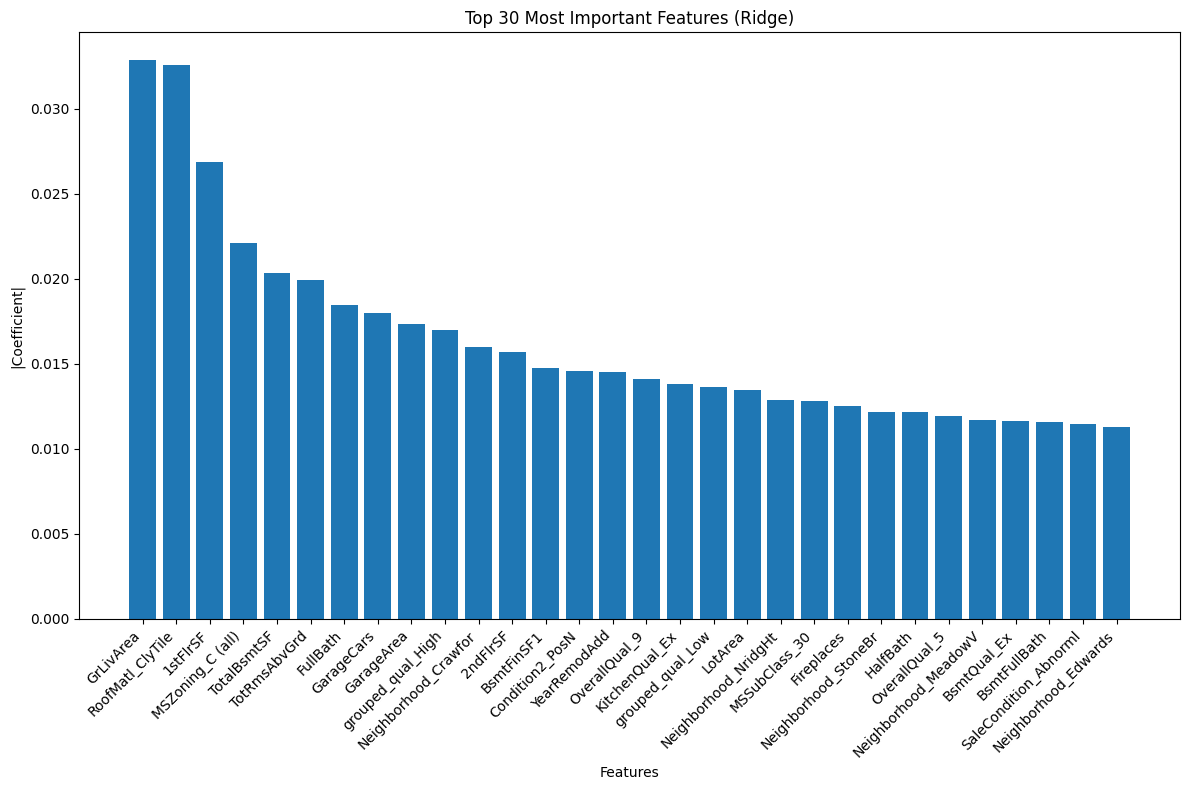

In [10]:
from sklearn.linear_model import RidgeCV

def plot_importance_ridge(importance, top_n=30):
    """
    Plot top N most important features
    """
    plt.figure(figsize=(12, 8))
    plt.bar(range(top_n), importance['coef'][:top_n])
    plt.xticks(range(top_n), importance['feature'][:top_n], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('|Coefficient|')
    plt.title(f'Top {top_n} Most Important Features (Ridge)')
    plt.tight_layout()
    return plt

def analyze_ridge_features():
    """
    Fit RidgeCV and analyze features
    """
    # Read data
    
    # Prepare data
    X, y, scaler = prepare_data(train_df)
    
    # Setup cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Try a wide range of alphas
    alphas = np.logspace(-2, 3, 100)  # from 0.01 to 1000
    
    # Fit RidgeCV
    ridge = RidgeCV(alphas=alphas, cv=cv, scoring='neg_mean_squared_error')
    ridge.fit(X, y)
    
    # Get feature importance
    importance = pd.DataFrame({
        'feature': X.columns,
        'coef': np.abs(ridge.coef_)
    })
    importance = importance.sort_values('coef', ascending=False)
    
    print(f"Optimal alpha: {ridge.alpha_:.6f}")
    print("\nTop 20 most important features:")
    print(importance.head(20).to_string(index=False))
    print(f"\nR2 score: {ridge.score(X, y):.4f}")
    
    # Return results for further analysis
    return importance, ridge, X, y

importance, model, X, y = analyze_ridge_features()
plot_importance_ridge(importance)

In [11]:
from sklearn.ensemble import RandomForestRegressor

def fit_models_and_get_importance(X, y):
    """
    Fit all three models and get their feature importance
    """
    # Setup cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Fit LassoCV
    lasso = LassoCV(cv=cv, random_state=42, max_iter=2000)
    lasso.fit(X, y)
    lasso_importance = pd.DataFrame({
        'feature': X.columns,
        'lasso_coef': np.abs(lasso.coef_)
    }).sort_values('lasso_coef', ascending=False)
    
    # Fit RidgeCV
    alphas = np.logspace(-2, 3, 100)
    ridge = RidgeCV(alphas=alphas, cv=cv)
    ridge.fit(X, y)
    ridge_importance = pd.DataFrame({
        'feature': X.columns,
        'ridge_coef': np.abs(ridge.coef_)
    }).sort_values('ridge_coef', ascending=False)
    
    # Fit Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'rf_importance': rf.feature_importances_
    }).sort_values('rf_importance', ascending=False)
    
    # Combine all importance scores
    importance = pd.merge(lasso_importance, ridge_importance, on='feature', how='outer')
    importance = pd.merge(importance, rf_importance, on='feature', how='outer')
    
    # Add rankings
    importance['lasso_rank'] = importance['lasso_coef'].rank(ascending=False)
    importance['ridge_rank'] = importance['ridge_coef'].rank(ascending=False)
    importance['rf_rank'] = importance['rf_importance'].rank(ascending=False)
    
    # Add mean rank
    importance['mean_rank'] = importance[['lasso_rank', 'ridge_rank', 'rf_rank']].mean(axis=1)
    importance = importance.sort_values('mean_rank')
    
    return importance, lasso, ridge, rf

def analyze_feature_importance():
    """
    Main analysis function
    """
    
    # Prepare data
    X, y, scaler = prepare_data(train_df)
    
    # Get importance
    importance, lasso, ridge, rf = fit_models_and_get_importance(X, y)
    
    # Print model scores
    print("Model R2 Scores:")
    print(f"Lasso R2: {lasso.score(X, y):.4f}")
    print(f"Ridge R2: {ridge.score(X, y):.4f}")
    print(f"RF R2: {rf.score(X, y):.4f}")
    
    # Print top features
    print("\nTop 20 Features by Mean Rank:")
    print(importance[['feature', 'lasso_rank', 'ridge_rank', 'rf_rank', 'mean_rank']].head(20).to_string(index=False))
    
    # Print model parameters
    print(f"\nLasso alpha: {lasso.alpha_:.6f}")
    print(f"Ridge alpha: {ridge.alpha_:.6f}")
    
    return importance, lasso, ridge, rf, X, y

if __name__ == "__main__":
    importance, lasso, ridge, rf, X, y = analyze_feature_importance()

Model R2 Scores:
Lasso R2: 0.9298
Ridge R2: 0.9314
RF R2: 0.9822

Top 20 Features by Mean Rank:
              feature  lasso_rank  ridge_rank  rf_rank  mean_rank
            GrLivArea         1.0         1.0      1.0   1.000000
          TotalBsmtSF         3.0         6.0      4.0   4.333333
    grouped_qual_High         4.0        10.0      2.0   5.333333
           GarageCars         8.0         8.0      8.0   8.000000
           GarageArea        13.0         9.0     11.0  11.000000
         YearRemodAdd         7.0        14.0     12.0  11.000000
           BsmtFinSF1        11.0        13.0      9.0  11.000000
     MSZoning_C (all)         5.0         4.0     27.0  12.000000
     grouped_qual_Low        10.0        18.0     13.0  13.666667
              LotArea        22.0        19.0     10.0  17.000000
            YearBuilt         6.0        45.0      3.0  18.000000
           Fireplaces        23.0        21.0     14.0  19.333333
        OverallQual_7        17.0        37.0 

In [12]:
from sklearn.decomposition import PCA

def perform_pca_analysis(df):
    """
    Perform PCA analysis and return results
    """
    # Prepare data
    X, y, scaler = prepare_data(df)
    
    # Fit PCA
    pca = PCA()
    pca_result = pca.fit_transform(X)
    
    # Calculate explained variance
    var_explained = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(var_explained)
    
    # Get component loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=X.columns
    )
    
    # Print summary
    print("\nPCA Summary:")
    print(f"Number of components: {pca.n_components_}")
    print("\nExplained variance by first 10 components:")
    for i in range(10):
        print(f"PC{i+1}: {var_explained[i]:.4f} ({cumulative_var[i]:.4f} cumulative)")
    
    # Get top features for first few components
    n_features = 10  # Number of top features to show
    n_components = 5  # Number of components to analyze
    
    print(f"\nTop {n_features} features for first {n_components} components:")
    for i in range(n_components):
        component = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
        print(f"\nPC{i+1} top features:")
        print(component.head(n_features).to_string())
    
    return pca, loadings, pca_result

def plot_explained_variance(pca):
    """
    Plot explained variance ratio and cumulative explained variance
    """
    var_explained = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(var_explained)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scree plot
    ax1.plot(range(1, len(var_explained) + 1), var_explained, 'bo-')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    
    # Cumulative variance plot
    ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance')
    ax2.axhline(y=0.8, color='gray', linestyle='--', label='80% threshold')
    ax2.legend()
    
    plt.tight_layout()
    return plt

def plot_component_heatmap(loadings, n_components=5, n_features=20):
    """
    Plot heatmap of component loadings
    """
    # Get top features for first n components
    top_features = set()
    for i in range(n_components):
        component = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
        top_features.update(component.head(n_features).index)
    
    # Create heatmap data
    heatmap_data = loadings.loc[list(top_features)].iloc[:, :n_components]
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='RdBu', center=0)
    plt.title(f'Component Loadings Heatmap\n(Top {n_features} features per component)')
    plt.tight_layout()
    return plt


PCA Summary:
Number of components: 367

Explained variance by first 10 components:
PC1: 0.0630 (0.0630 cumulative)
PC2: 0.0302 (0.0932 cumulative)
PC3: 0.0259 (0.1191 cumulative)
PC4: 0.0222 (0.1413 cumulative)
PC5: 0.0209 (0.1623 cumulative)
PC6: 0.0178 (0.1801 cumulative)
PC7: 0.0147 (0.1948 cumulative)
PC8: 0.0138 (0.2087 cumulative)
PC9: 0.0135 (0.2222 cumulative)
PC10: 0.0117 (0.2338 cumulative)

Top 10 features for first 5 components:

PC1 top features:
YearBuilt           0.178131
GarageYrBlt         0.169855
GarageCars          0.154905
GarageArea          0.145118
Foundation_PConc    0.144679
ExterQual_TA        0.144501
YearRemodAdd        0.138429
ExterQual_Gd        0.134000
BsmtQual_TA         0.124329
TotalBsmtSF         0.123070

PC2 top features:
Foundation_CBlock             0.168454
GarageCond_grouped_Low        0.149104
has_garage                    0.142351
GarageFinish_NA               0.142351
GarageQual_NA                 0.142351
GarageCond_NA                 0

<module 'matplotlib.pyplot' from 'c:\\Users\\Kyryl\\Projects\\ds\\Kaggle\\house_prices\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

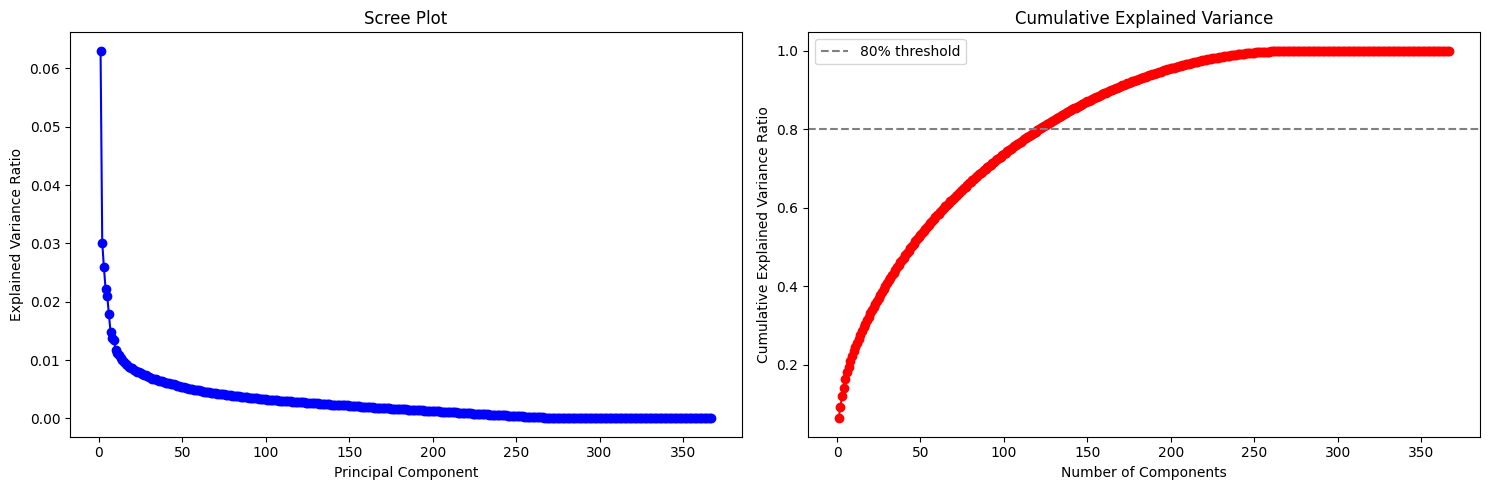

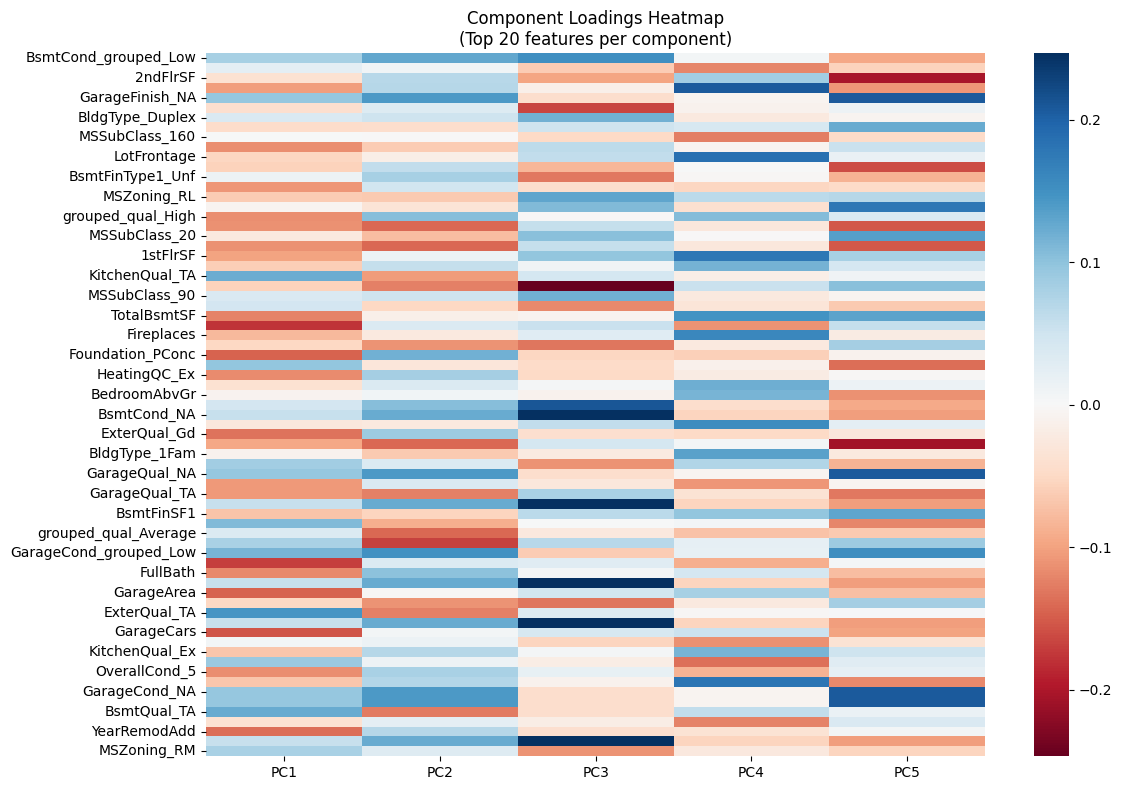

In [13]:
pca, loadings, pca_result = perform_pca_analysis(train_df)
    
plot_explained_variance(pca)
plot_component_heatmap(loadings)

# return pca, loadings, pca_result

In [14]:
def encode(df, feature):
  df = df.copy()
  ordering = pd.DataFrame()
  ordering["val"] = df[feature].unique()
  ordering = ordering.set_index('val')
  # ordering.index = ordering.val
  ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature, observed=True).mean()['SalePrice']
  ordering = ordering.sort_values('spmean')
  ordering['ordering'] = range(1, ordering.shape[0] + 1)
  ordering = ordering['ordering'].to_dict()

  for cat, o in ordering.items():
    df.loc[df[feature] == cat, feature + '_E'] = o

  return df


In [15]:
features_to_drop = [
    "Id",
    "garage_area_reasonable",
    "lot_frontage_missing",
    "garage_type_consistent",
    "garage_features_consistent",
    "basement_features_consistent",
    "has_consistent_second_finished_area",
    "basement_areas_match",
    "mas_vnr_consistent",
]


df = train_df.drop(features_to_drop, axis=1)

cat_vars = list(df.select_dtypes(include=["category"]).columns)
num_vars = list(df.select_dtypes(exclude=["category"]).columns)

qual_encoded = []
for cat in cat_vars:
    df = encode(df, cat)
    qual_encoded.append(cat + "_E")

print(qual_encoded)

['MSSubClass_E', 'MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'OverallQual_E', 'OverallCond_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E', 'grouped_qual_E', 'grouped_cond_E', 'ExterCond_grouped_E', 'BsmtCond_grouped_E', 'GarageCond_grouped_E']


In [16]:
def spearman(df, features):
  df = df.copy()
  spr = pd.DataFrame()
  spr['feature'] = features
  spr['spearman'] = [df[f].corr(df['SalePrice'], 'spearman') for f in features]
  return spr.sort_values('spearman')


In [17]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)

In [18]:
features = num_vars + qual_encoded

spr = spearman(df, features)
print(spr)

                 feature  spearman
26         EnclosedPorch -0.218394
18          KitchenAbvGr -0.164826
11          LowQualFinSF -0.067719
30               MiscVal -0.062727
6             BsmtFinSF2 -0.038806
32                YrSold -0.029899
14          BsmtHalfBath -0.012189
42           Utilities_E  0.016710
38              Street_E  0.045814
44           LandSlope_E  0.050310
29              PoolArea  0.058453
77              PoolQC_E  0.058495
27             3SsnPorch  0.065440
31                MoSold  0.069432
79         MiscFeature_E  0.078318
53            RoofMatl_E  0.090497
28           ScreenPorch  0.100070
43           LotConfig_E  0.105029
47          Condition2_E  0.107173
65             Heating_E  0.121949
84   ExterCond_grouped_E  0.129414
39               Alley_E  0.130207
58           ExterCond_E  0.130370
70          Functional_E  0.136477
48            BldgType_E  0.151785
41         LandContour_E  0.154423
64        BsmtFinType2_E  0.158796
52           RoofSty

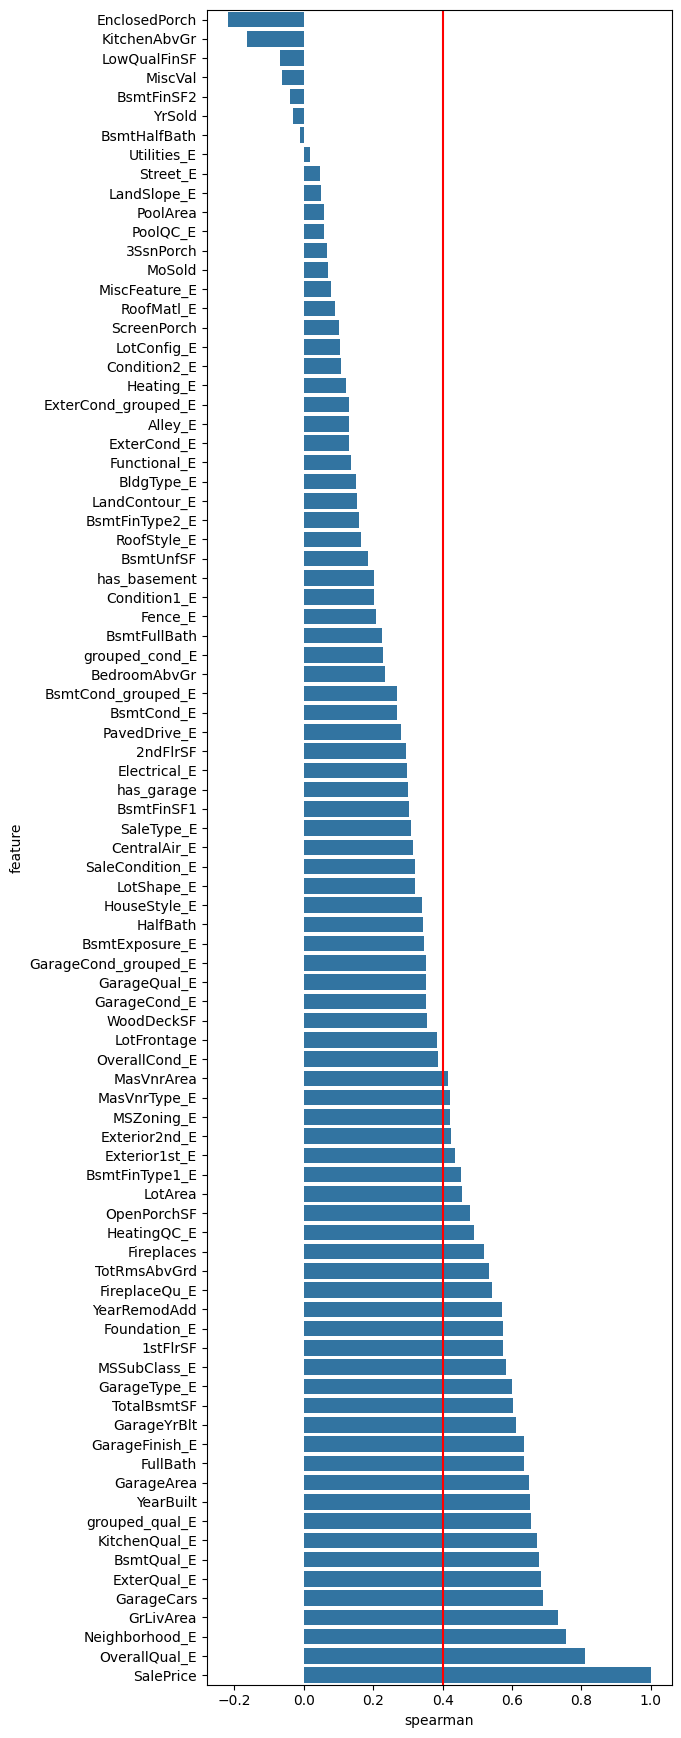

In [19]:
fig, ax = plt.subplots(figsize=(6, 0.25*len(features)))
sns.barplot(data=spr, y='feature', x='spearman', orient='h', ax = ax)
ax.axvline(x=0.4, color = 'red')
plt.show()

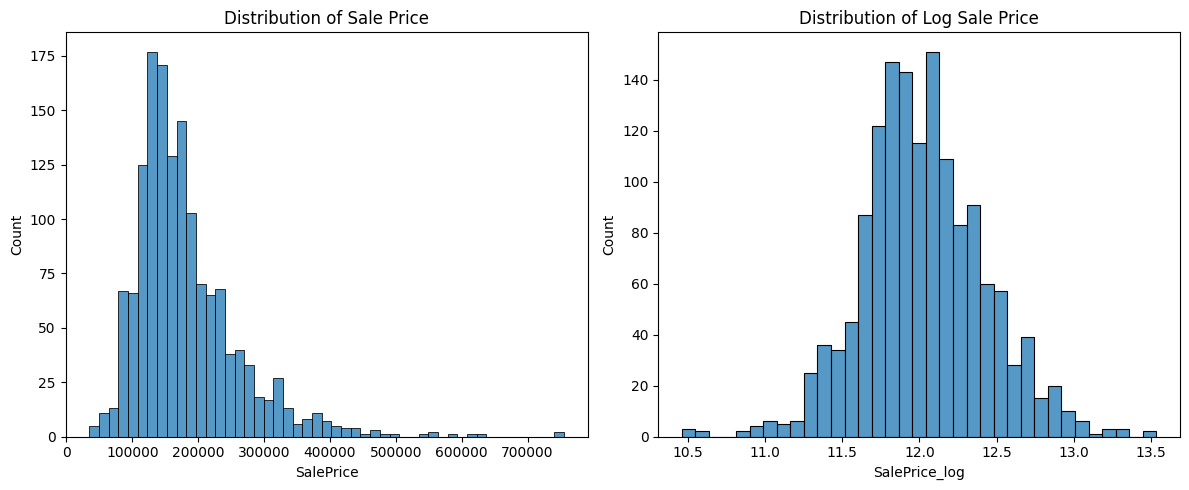

In [20]:
df['SalePrice_log'] = np.log(df['SalePrice']) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
sns.histplot(data= df, x = 'SalePrice', ax = ax1)
ax1.set_title("Distribution of Sale Price")
sns.histplot(data = df, x = 'SalePrice_log', ax = ax2)
ax2.set_title("Distribution of Log Sale Price")
plt.tight_layout()
plt.show()

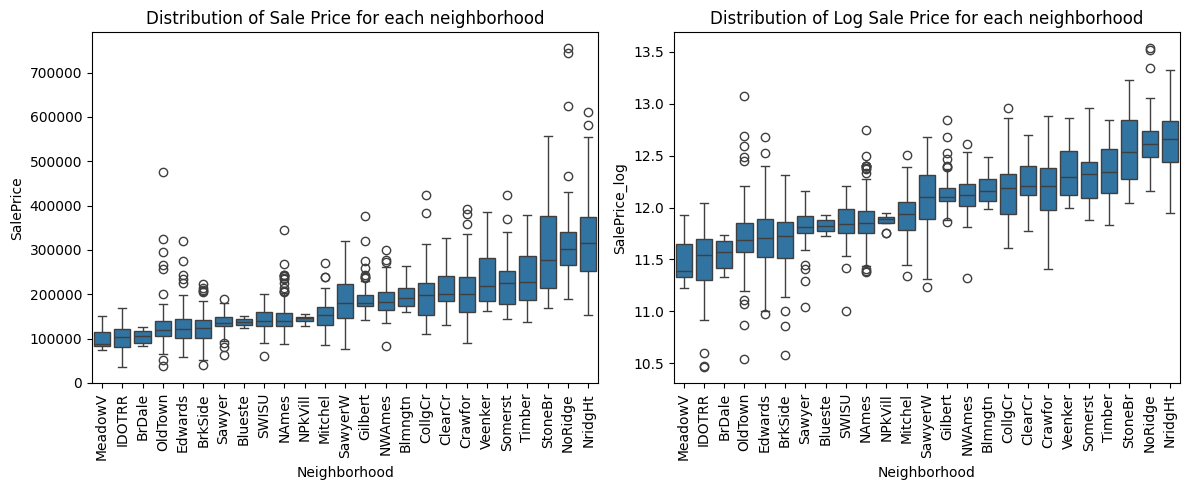

In [21]:
medians = df.groupby("Neighborhood", observed=True)['SalePrice'].median().sort_values()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
sns.boxplot(data= df, x = 'Neighborhood', y = 'SalePrice', ax = ax1, order=medians.index)
sns.boxplot(data = df, x = 'Neighborhood', y = 'SalePrice_log', ax = ax2, order=medians.index)
ax1.tick_params(axis='x', rotation=90)
ax1.set_title("Distribution of Sale Price for each neighborhood")
ax2.set_title("Distribution of Log Sale Price for each neighborhood")
ax2.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

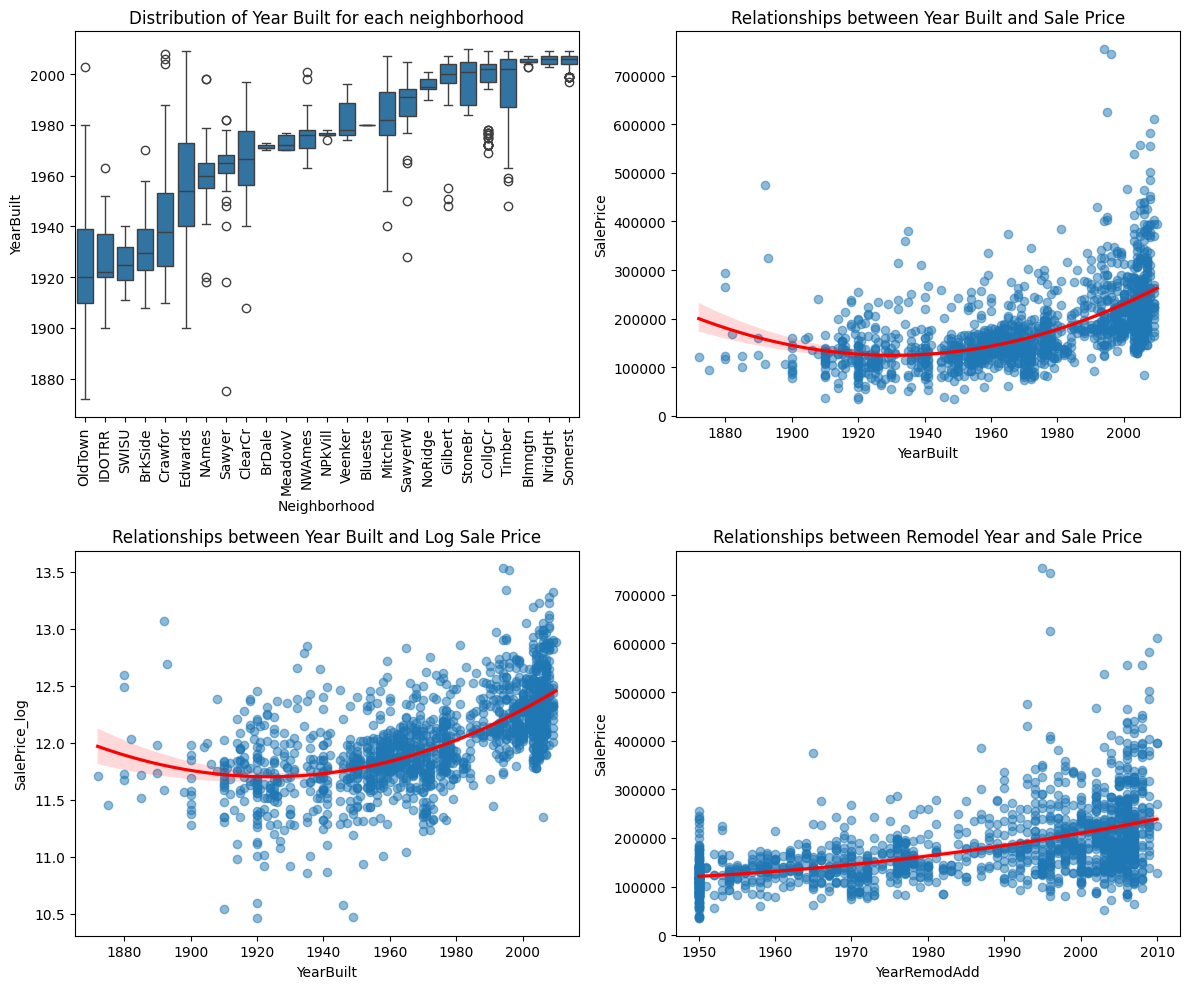

In [22]:
medians_nb = df.groupby("Neighborhood", observed=True)['YearBuilt'].median().sort_values()
medians_yr = df.groupby('YearBuilt', observed=True)['SalePrice'].median().sort_values()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 10))

sns.boxplot(data = df, x = 'Neighborhood', y = "YearBuilt", order=medians_nb.index, ax = ax1)
ax1.tick_params(axis='x', rotation=90)
ax1.set_title("Distribution of Year Built for each neighborhood")
sns.regplot(data = df, x = 'YearBuilt', y = "SalePrice", scatter_kws={'alpha':0.5}, order=2, line_kws={'color': 'red'}, ax = ax2)
ax2.set_title("Relationships between Year Built and Sale Price")
sns.regplot(data = df, x = 'YearBuilt', y = "SalePrice_log", scatter_kws={'alpha':0.5}, order=2, line_kws={'color': 'red'}, ax = ax3)
ax3.set_title("Relationships between Year Built and Log Sale Price")
sns.regplot(data = df, x = 'YearRemodAdd', y = "SalePrice", scatter_kws={'alpha':0.5}, order=2, line_kws={'color': 'red'},  ax = ax4)
ax4.set_title("Relationships between Remodel Year and Sale Price")
plt.tight_layout()
plt.show()

In [23]:
def create_price_heatmap(df, bin_size=5):
    # Create a copy of the dataframe
    df = df.copy()
    
    # Create a flag for actually renovated houses
    df['IsRenovated'] = df['YearRemodAdd'] > df['YearBuilt']
    
    # Create year bins to aggregate data
    year_built_bins = np.arange(df['YearBuilt'].min() - (df['YearBuilt'].min() % bin_size), 
                               df['YearBuilt'].max() + bin_size, 
                               bin_size)
    year_remod_bins = np.arange(df['YearRemodAdd'].min() - (df['YearRemodAdd'].min() % bin_size), 
                               df['YearRemodAdd'].max() + bin_size, 
                               bin_size)
    
    # Create bin labels for axes
    year_built_labels = [f'{year}-{year+bin_size-1}' for year in year_built_bins[:-1]]
    year_remod_labels = [f'{year}-{year+bin_size-1}' for year in year_remod_bins[:-1]]
    
    # Bin the years
    df['YearBuilt_bin'] = pd.cut(df['YearBuilt'], bins=year_built_bins, labels=year_built_labels)
    df['YearRemodAdd_bin'] = pd.cut(df['YearRemodAdd'], bins=year_remod_bins, labels=year_remod_labels)
    df['SalePrice_k'] = df['SalePrice'] / 1000
    
    # Filter only renovated houses
    df_renovated = df[df['IsRenovated']]
    
    # Calculate mean price for each combination
    pivot_table = df_renovated.pivot_table(values='SalePrice_k', 
                                         index='YearRemodAdd_bin',
                                         columns='YearBuilt_bin',
                                         aggfunc=['mean', 'count']).round()
    
    # Sort index in descending order to make years increase upward
    pivot_table_mean = pivot_table['mean'].sort_index(ascending=False)
    pivot_table_count = pivot_table['count'].sort_index(ascending=False)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Create heatmap for average prices
    sns.heatmap(pivot_table_mean, 
                cmap='YlOrRd',
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Average Sale Price ($1000)'},
                mask=pivot_table_mean.isna(),
                ax=ax1)
    
    ax1.set_title('Average House Price (Renovated Houses Only)')
    ax1.set_xlabel('Year Built')
    ax1.set_ylabel('Year of Renovation')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Create heatmap for counts
    sns.heatmap(pivot_table_count, 
                cmap='YlGnBu',
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Number of Houses'},
                mask=pivot_table_count.isna(),
                ax=ax2)
    
    ax2.set_title('Number of Houses (Renovated Only)')
    ax2.set_xlabel('Year Built')
    ax2.set_ylabel('Year of Renovation')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Print some summary statistics
    n_renovated = df['IsRenovated'].sum()
    pct_renovated = (n_renovated / len(df)) * 100
    print(f"Total houses: {len(df)}")
    print(f"Renovated houses: {n_renovated} ({pct_renovated:.1f}%)")
    
    return fig


Total houses: 1196
Renovated houses: 489 (40.9%)


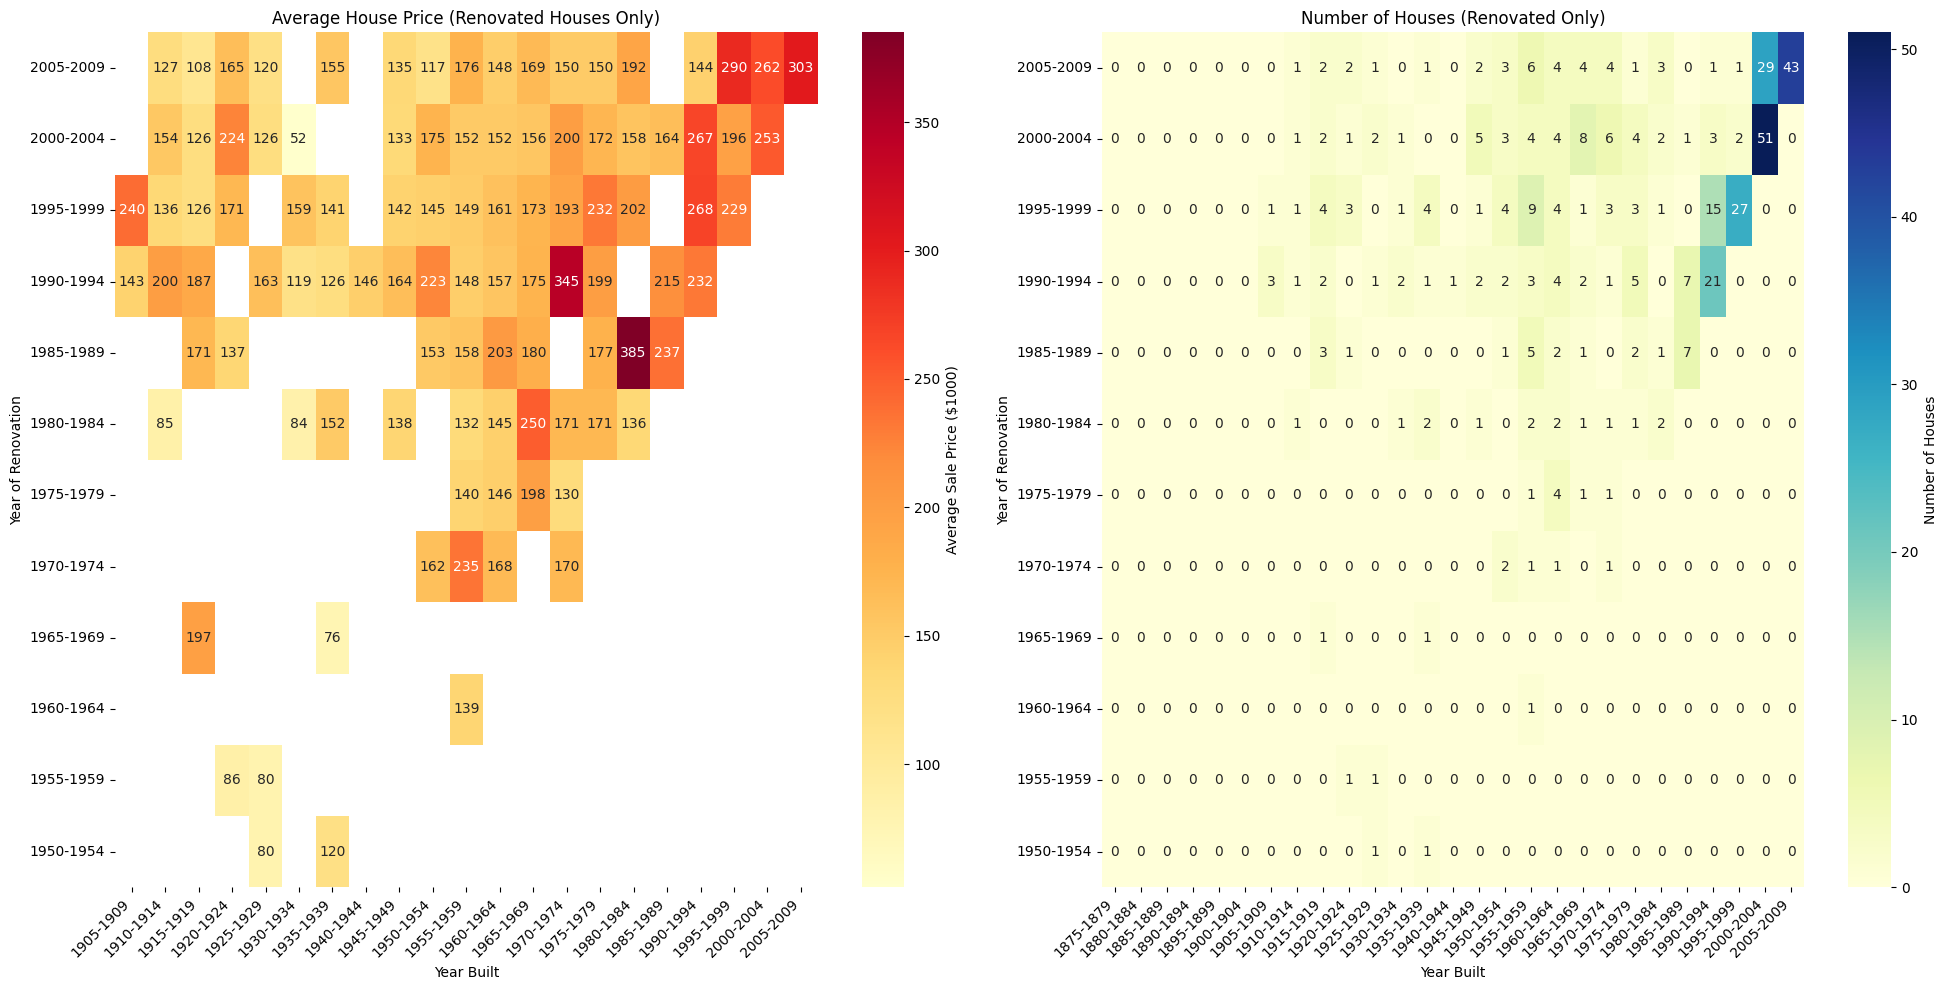

In [24]:
fig = create_price_heatmap(df)

In [25]:
# I didn't find any strong patterns in YearBuilt vs YearRemodAdd vs SalePrice plots.

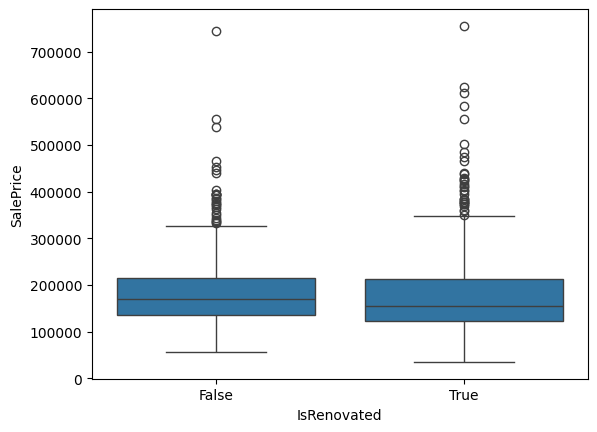

In [32]:
df['IsRenovated'] = df['YearRemodAdd'] > df['YearBuilt']
sns.boxplot(data = df, x = "IsRenovated", y = "SalePrice")
plt.show()

In [25]:
# Renovated houses show no significant difference patterns in price

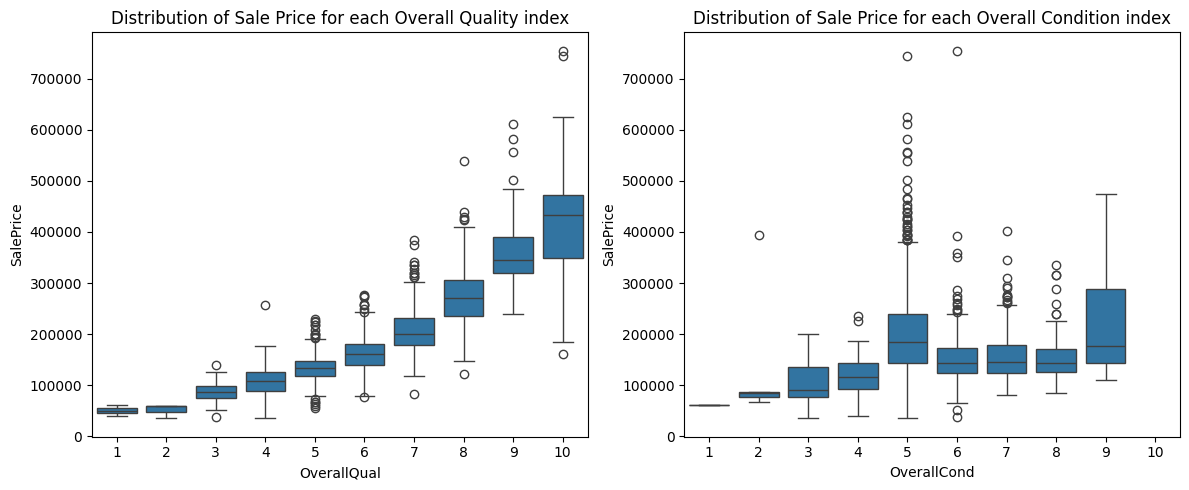

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
sns.boxplot(data = df, x = 'OverallQual', y = 'SalePrice', ax = ax1)
ax1.set_title("Distribution of Sale Price for each Overall Quality index")
sns.boxplot(data = df, x = 'OverallCond', y = 'SalePrice', ax = ax2)
ax2.set_title("Distribution of Sale Price for each Overall Condition index")
plt.tight_layout()
plt.show()

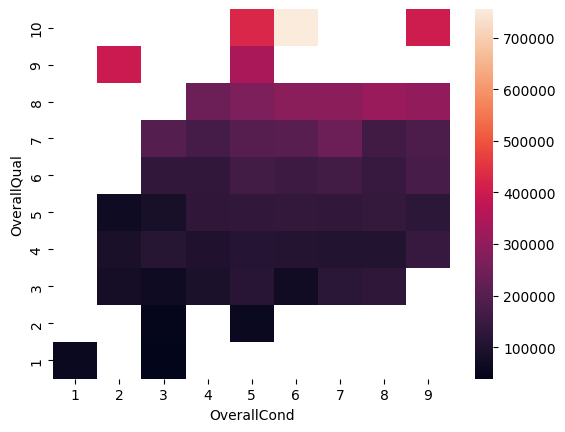

In [34]:
qual_vs_cond_median_price = pd.pivot_table(data = df, index = "OverallQual", columns = "OverallCond", values="SalePrice", aggfunc="median").sort_index(ascending=False)
sns.heatmap(data=qual_vs_cond_median_price, mask=qual_vs_cond_median_price.isna())
plt.show()

In [28]:
print(df['OverallQual'].value_counts(sort=False))
print("\n\n")
print(df['OverallCond'].value_counts(sort=False))

OverallQual
1       2
2       3
3      20
4     116
5     397
6     374
7     319
8     168
9      43
10     18
Name: count, dtype: int64



OverallCond
1       1
2       5
3      25
4      57
5     821
6     252
7     205
8      72
9      22
10      0
Name: count, dtype: int64


In [30]:
# There is class imbalance in both quality and condition categories
# so i cut them in larger classes

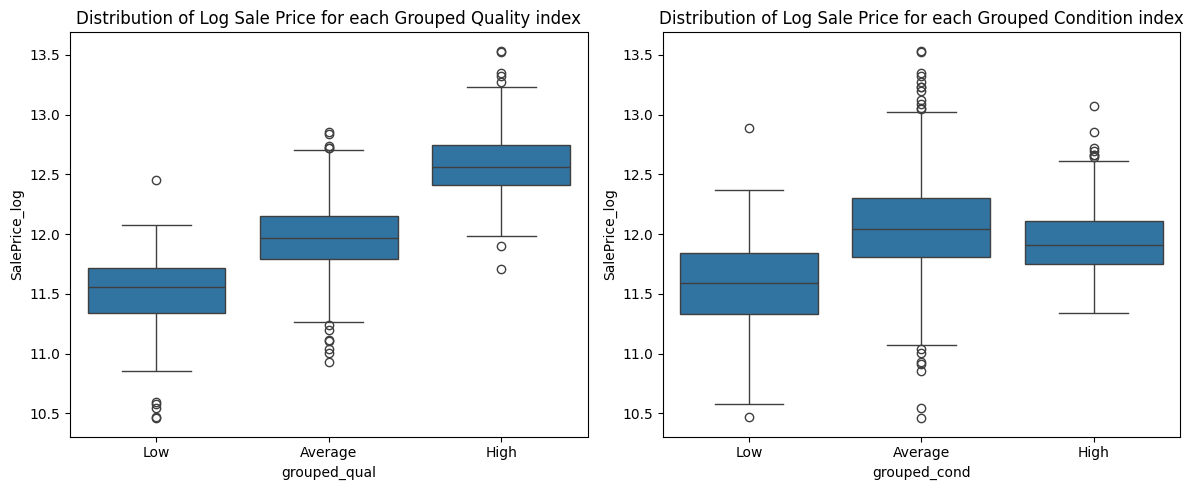

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
sns.boxplot(data = df, x = 'grouped_qual', y = 'SalePrice_log', ax = ax1)
ax1.set_title("Distribution of Log Sale Price for each Grouped Quality index")
sns.boxplot(data = df, x = 'grouped_cond', y = 'SalePrice_log', ax = ax2)
ax2.set_title("Distribution of Log Sale Price for each Grouped Condition index")
plt.tight_layout()
plt.show()

ExterCond
Po       1
Fa      28
TA    1282
Gd     146
Ex       3
Name: count, dtype: int64



BsmtCond
NA      37
Po       2
Fa      45
TA    1311
Gd      65
Ex       0
Name: count, dtype: int64



GarageCond
NA      81
Po       7
Fa      35
TA    1326
Gd       9
Ex       2
Name: count, dtype: int64





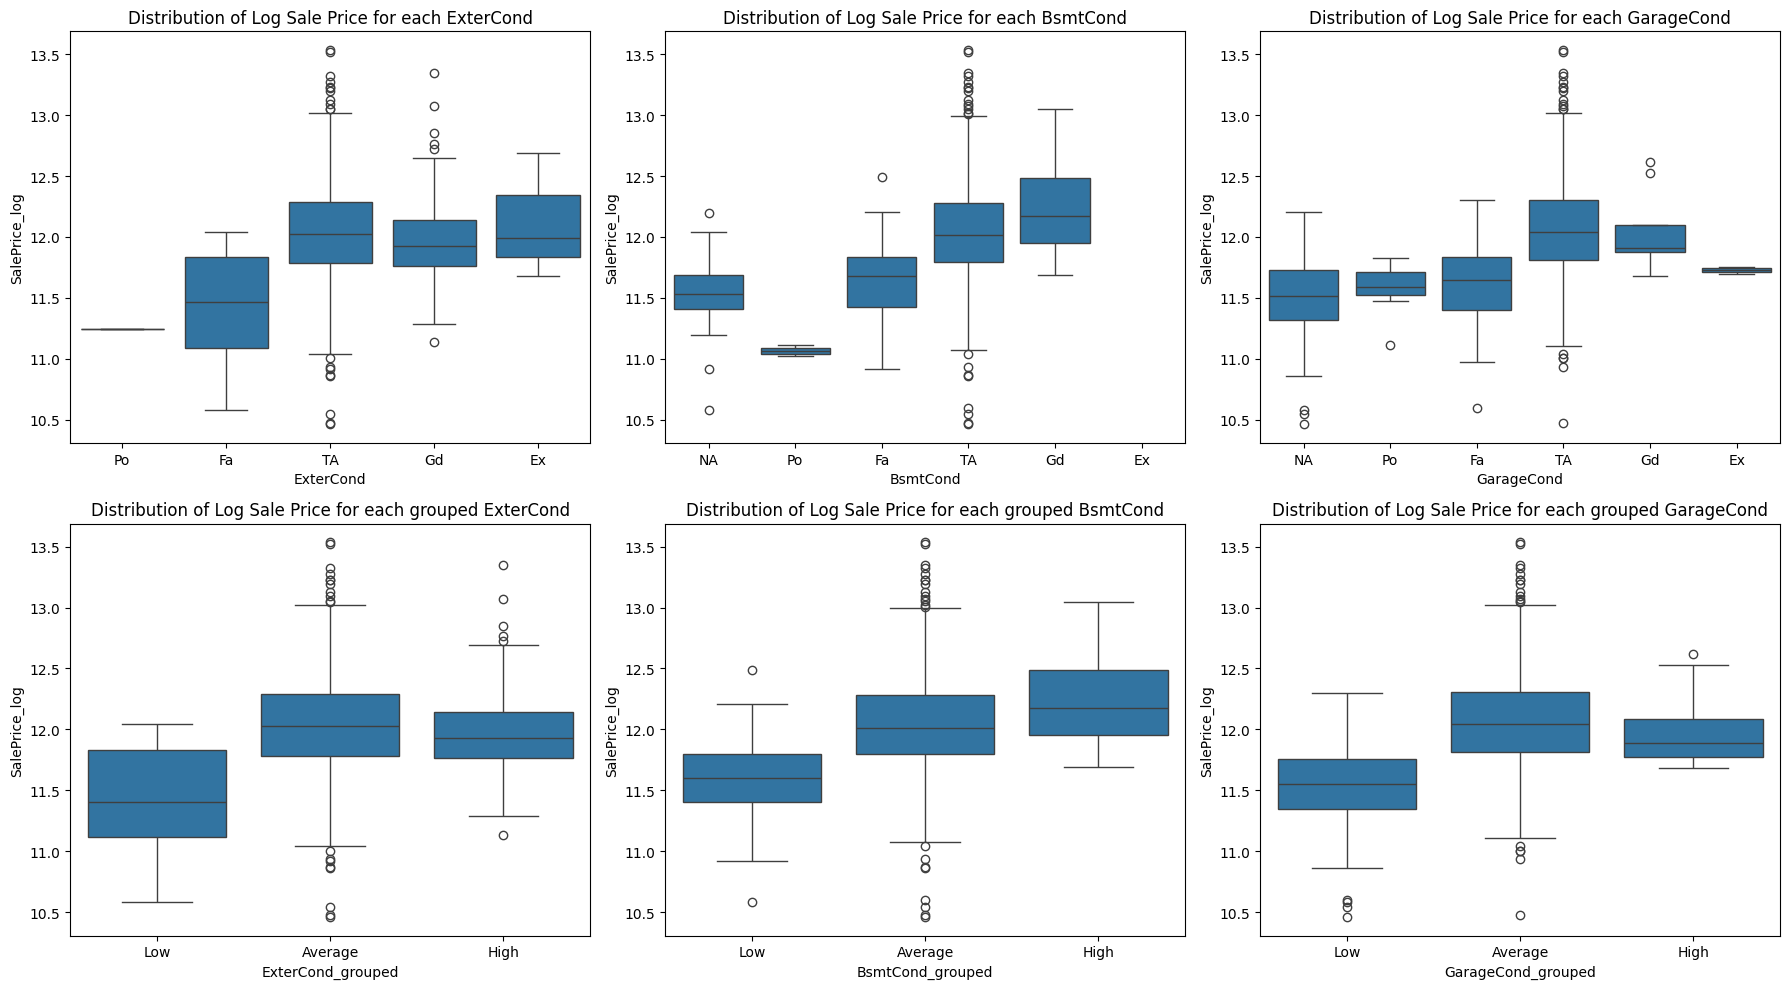

In [43]:
cond_vars = ["ExterCond", "BsmtCond", "GarageCond", ]

for var in cond_vars:
  print(df[var].value_counts(sort=False))
  print("\n\n")

fig, axes = plt.subplots(2, 3, figsize = (18, 10))
for i, var in enumerate(cond_vars):
  sns.boxplot(data= df, x = var, y = 'SalePrice_log', ax = axes[0, i])
  axes[0, i].set_title(f"Distribution of Log Sale Price for each {var}")
  sns.boxplot(data= df, x = f"{var}_grouped", y = 'SalePrice_log', ax = axes[1, i])
  axes[1, i].set_title(f"Distribution of Log Sale Price for each grouped {var}")

plt.tight_layout()
plt.show()

In [48]:
print(train_df["ExterQual"].value_counts(sort=False))
print(train_df["BsmtQual"].value_counts(sort=False))
print(train_df["KitchenQual"].value_counts(sort=False))
print(train_df["GarageQual"].value_counts(sort=False))

ExterQual
Po      0
Fa     14
TA    906
Gd    488
Ex     52
Name: count, dtype: int64
BsmtQual
NA     37
Po      0
Fa     35
TA    649
Gd    618
Ex    121
Name: count, dtype: int64
KitchenQual
Po      0
Fa     39
TA    735
Gd    586
Ex    100
Name: count, dtype: int64
GarageQual
NA      81
Po       3
Fa      48
TA    1311
Gd      14
Ex       3
Name: count, dtype: int64
